In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/efficientnet_clahe.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/CLAHE/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/CLAHE/val'
TEST_IMAGE_FOLDER = '/home/TBX11K/CLAHE/test'
SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

### EfficientNet Model

In [3]:
#load pretrained efficientnet model fine-tuned on our dataset
from tensorflow import keras
eff_model = keras.models.load_model('./weights/efficientnet_adam_dropout.hdf5')
eff_model.summary()

2022-08-16 04:24:55.499072: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-16 04:24:55.499154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

#### Keras Callbacks

In [4]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(eff_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(eff_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 9130 images belonging to 3 classes.
Found 2032 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.972310969116081, 1: 1.0144444444444445, 2: 1.0144444444444445}
samples for train class labels: dict_items([(0, 3130), (1, 3000), (2, 3000)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 923), (1, 800), (2, 309)])


#### EfficientNet Compilation and Execution

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
eff_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [7]:
warnings.filterwarnings("ignore")
epochs = 30
history = eff_model.fit(train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=validation_generator, 
                                epochs=epochs,
                                verbose = 1,
                                class_weight = class_weights,
                                callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 1/30


2022-08-16 04:25:17.606669: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


286/286 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9368 - AUC: 0.9911 - precision: 0.9411 - recall: 0.9337
Epoch 00001: val_loss improved from inf to 0.27051, saving model to ./weights/efficientnet_clahe.hdf5
End of epoch 0. Learning rate: 1e-04
286/286 [==============================] - 129s 417ms/step - loss: 0.1720 - accuracy: 0.9368 - AUC: 0.9911 - precision: 0.9411 - recall: 0.9337 - val_loss: 0.2705 - val_accuracy: 0.8858 - val_AUC: 0.9801 - val_precision: 0.8895 - val_recall: 0.8839 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 2/30
286/286 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9640 - AUC: 0.9968 - precision: 0.9659 - recall: 0.9625
Epoch 00002: val_loss improved from 0.27051 to 0.23537, saving model to ./weights/efficientnet_clahe.hdf5
End of epoch 1. Learning rate: 1e-04
286/286 [==============================] - 121s 422ms/step - loss: 0.0972 - accuracy: 0.9640 - AUC: 0.9968 - precision: 0.9659 - recall: 0.9625 - v

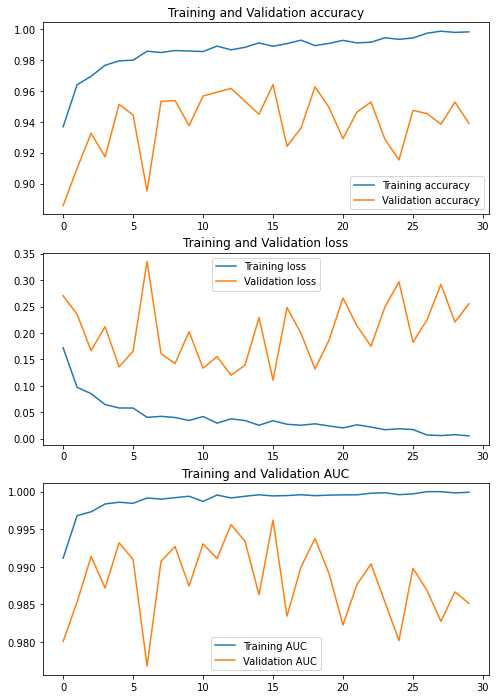

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
15,0.034026,0.988828,0.999420,0.989257,0.988390,0.110925,0.964075,0.996206,0.965007,0.963583,0.000100
12,0.037534,0.986528,0.999153,0.987170,0.985980,0.120033,0.961614,0.995615,0.962543,0.961122,0.000100
18,0.028080,0.989266,0.999455,0.989807,0.989157,0.131917,0.962598,0.993767,0.962598,0.962598,0.000100
10,0.041864,0.985433,0.998693,0.986075,0.984995,0.133465,0.956693,0.993047,0.958045,0.955217,0.000100
4,0.058095,0.979409,0.998584,0.979713,0.978532,0.136062,0.951280,0.993198,0.953086,0.949803,0.000100
13,0.034302,0.988171,0.999382,0.989144,0.987952,0.139133,0.953248,0.993383,0.953649,0.951772,0.000100
8,0.040031,0.986090,0.999192,0.986405,0.985433,0.142213,0.953740,0.992689,0.954187,0.953248,0.000100
11,0.029274,0.988938,0.999540,0.989477,0.988719,0.155165,0.959154,0.991095,0.960099,0.959154,0.000100
7,0.042210,0.984775,0.998993,0.985312,0.984556,0.160832,0.953248,0.990745,0.953717,0.953248,0.000100


#### EfficientNet Fine tuning

In [16]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
eff_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [17]:
history_finetune = eff_model.fit(train_generator,
                            epochs=40,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 30/40
286/286 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990 - AUC: 1.0000 - precision: 0.9990 - recall: 0.9990
Epoch 00030: val_loss did not improve from 0.11093
End of epoch 29. Learning rate: 1e-05
286/286 [==============================] - 130s 431ms/step - loss: 0.0031 - accuracy: 0.9990 - AUC: 1.0000 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.3022 - val_accuracy: 0.9326 - val_AUC: 0.9810 - val_precision: 0.9330 - val_recall: 0.9321 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 31/40
286/286 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9991 - AUC: 0.9999 - precision: 0.9991 - recall: 0.9991
Epoch 00031: val_loss did not improve from 0.11093
End of epoch 30. Learning rate: 1e-05
286/286 [==============================] - 123s 430ms/step - loss: 0.0032 - accuracy: 0.9991 - AUC: 0.9999 - precision: 0.9991 - recall: 0.9991 - val_loss: 0.2739 - val_accuracy: 0.9424 - val_AUC: 

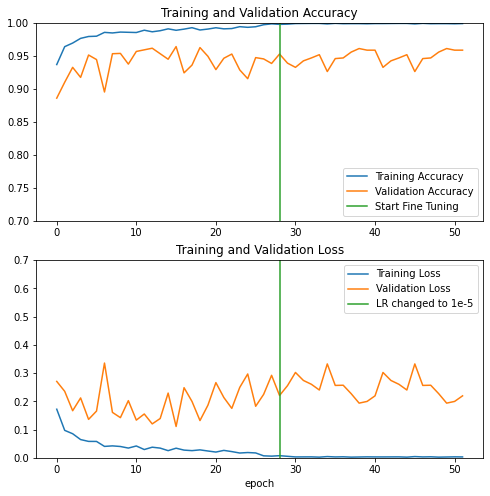

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.7])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='LR changed to 1e-5')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
8,0.002853,0.998905,0.999997,0.998905,0.998905,0.193588,0.961122,0.989893,0.961103,0.960630,0.00001
9,0.003347,0.998686,0.999915,0.998686,0.998686,0.199641,0.958661,0.988360,0.959586,0.958169,0.00001
10,0.003082,0.999014,0.999997,0.999014,0.999014,0.219408,0.958661,0.986316,0.959133,0.958661,0.00001
7,0.002334,0.998905,0.999999,0.998905,0.998905,0.227117,0.955709,0.986304,0.955687,0.955217,0.00001
3,0.002313,0.999233,0.999999,0.999233,0.999233,0.240061,0.951772,0.985740,0.951748,0.951280,0.00001
5,0.003072,0.999343,0.999915,0.999343,0.999343,0.256306,0.945866,0.985347,0.945839,0.945374,0.00001
6,0.003564,0.998795,0.999996,0.998795,0.998686,0.256969,0.946850,0.984624,0.947291,0.946358,0.00001
2,0.003290,0.999233,0.999996,0.999233,0.999233,0.260335,0.946850,0.985085,0.947317,0.946850,0.00001
1,0.003186,0.999124,0.999915,0.999124,0.999124,0.273878,0.942421,0.982583,0.942421,0.942421,0.00001


#### Montgomery County Dataset Evaluation

In [22]:
TEST_IMAGE_FOLDER = '/home/TBX11K/CLAHE/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

model = tf.keras.models.load_model('./weights/efficientnet_clahe.hdf5')
res = model.predict(test_generator)

Found 69 images belonging to 3 classes.


In [23]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        40
           1       0.00      0.00      0.00         0
           2       0.72      0.62      0.67        29

    accuracy                           0.72        69
   macro avg       0.49      0.47      0.48        69
weighted avg       0.74      0.72      0.73        69



#### Shenzhen Dataset Evaluation

In [24]:
TEST_IMAGE_FOLDER = '/home/TBX11K/CLAHE/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 331 images belonging to 3 classes.


In [25]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       163
           2       0.88      0.82      0.85       168

    accuracy                           0.85       331
   macro avg       0.85      0.85      0.85       331
weighted avg       0.85      0.85      0.85       331

